In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
%cd ..

/cis/home/dpacker/my_documents/dark-matter-halos


In [2]:
from pathlib import Path
import pickle
import pandas as pd
from src.classical.classical_approach import load_data
from src.subsampling.subsample import fix_torus, aggregate_velocities, recenter
from jax import numpy as jnp
import jax
from src.summarize.oat import oat_validate_knn
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from src.gw.lower_bounds import second

In [3]:
root_path = Path(".")
data_path = root_path / "data"
gen_data_path = root_path / "generated_data"

points_array, properties = pickle.load(open(data_path / "halos.pkl", 'rb'))
# test_indices = list(pd.read_csv(data_path / "test_indices.txt", header=None)[0])
# train_indices = list(pd.read_csv(data_path / "train_indices.txt", header=None)[0])
# val_indices = list(pd.read_csv(data_path / "val_indices.txt", header=None)[0])
# classical_data = load_data(data_path)

G = 4.30219372e10 / 1e6
logc = jnp.log10(
    properties["SubhaloVmax"]
    / jnp.sqrt(G * properties["Group_M_Mean200"] / properties["Group_R_Mean200"])
)
logc_dists = jnp.abs(logc[:, None] - logc[None, :])

In [5]:
t = 0
subsampled_data = jnp.load(gen_data_path / "kmeans_subsampled_n2_s75.npz")
weights_subsampled = subsampled_data["weights"]
points_subsampled = subsampled_data["points"]
velocities_subsampled = subsampled_data["velocities"]
p, q = 1, 1

dispersion = lambda pts: jnp.sqrt(jnp.trace(jnp.cov(pts.T)))

def slb_func(p: float, q: float):
    def compute_slb(
        cloud_a: jnp.ndarray,
        cloud_b: jnp.ndarray,
        weights_a: jnp.ndarray,
        weights_b: jnp.ndarray,
    ):
        cost_matrix_a = second.cost_matrix(cloud_a)
        cost_matrix_b = second.cost_matrix(cloud_b)

        return second.second_lower_bound(
            cost_matrix_a, cost_matrix_b, weights_a, weights_b, p, q
        )


    get_slb_dists_with = jax.vmap(compute_slb, [0, None, 0, None])
    get_slb_dists = jax.vmap(get_slb_dists_with, [None, 0, None, 0])
    return get_slb_dists

slb_dists = slb_func(p, q)(points_subsampled[:, t], points_subsampled[:, t], weights_subsampled[:, t], weights_subsampled[:, t])

  0%|          | 0/50 [00:00<?, ?it/s]

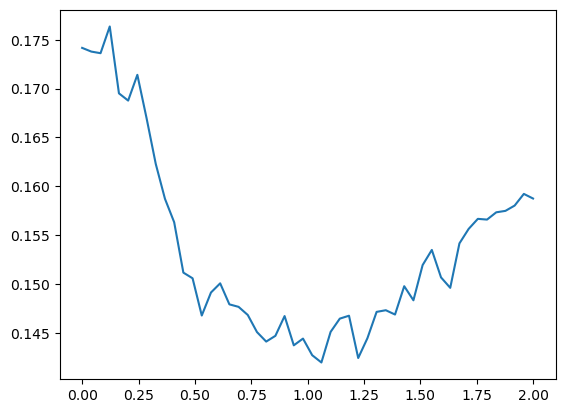

In [10]:
# Compute SLB in phase space
labels = jnp.log10(properties["GroupStellarMass"] * 1e10 / 0.677)  # label by logMstar
phis = np.linspace(0.0, 2.0)  # Conversion from velocities to coordinates, units of time
losses = []
for alpha in tqdm(phis):
    k = 5
    weighting = "uniform"

    phase_subsampled = jnp.concatenate(
        [points_subsampled, alpha * velocities_subsampled], axis=-1
    )
    slb_phase_dists = slb_func(p, q)(
        phase_subsampled[:, t],
        phase_subsampled[:, t],
        weights_subsampled[:, t],
        weights_subsampled[:, t],
    )
    losses.append(oat_validate_knn(slb_phase_dists, labels, k, weighting))

plt.plot(phis, losses)

In [11]:
from itertools import product

n_p, n_q = 10, 10
ps = np.linspace(0.5, 5, num=n_p)
qs = np.linspace(0.1, 2, num=n_q)
phi = 1.0

loss_matrix = np.zeros([n_p, n_q])

for (p_ix, p), (q_ix, q) in tqdm(list(product(enumerate(ps), enumerate(qs)))):
    slb_phase_dists = slb_func(p, q)(
        phase_subsampled[:, t],
        phase_subsampled[:, t],
        weights_subsampled[:, t],
        weights_subsampled[:, t],
    )
    loss_matrix[p_ix, q_ix] = oat_validate_knn(
        slb_phase_dists, labels, k, weighting
    )

  0%|          | 0/100 [00:00<?, ?it/s]

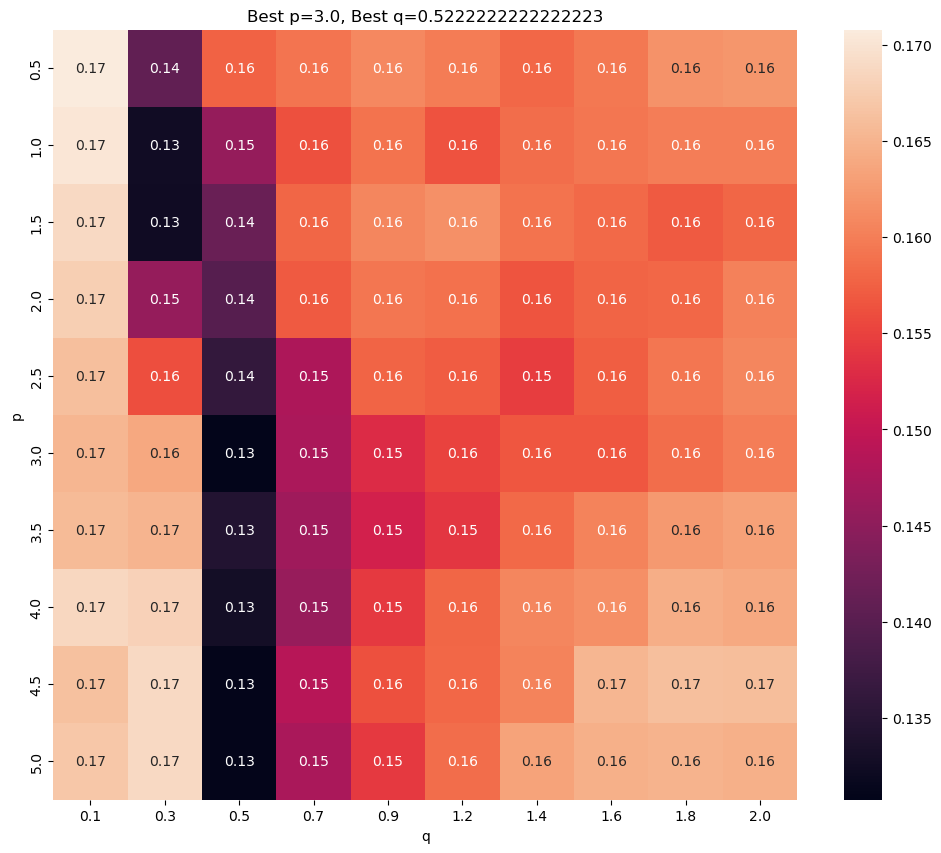

In [43]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 10))
loss_df = pd.DataFrame(loss_matrix, index=np.round(ps, 1), columns=np.round(qs, 1))
sns.heatmap(loss_df, annot=True, ax=ax)

best_p_ix, best_q_ix = np.unravel_index(np.argmin(loss_matrix), loss_matrix.shape)
best_p, best_q = ps[best_p_ix], qs[best_q_ix]

ax.set(xlabel="q", ylabel="p", title=f"Best p={best_p}, Best q={best_q}");

In [14]:
slb_phase_dists = slb_func(0.2, 0.2)(
    phase_subsampled[:, t],
    phase_subsampled[:, t],
    weights_subsampled[:, t],
    weights_subsampled[:, t],
)

In [15]:
labels = jnp.log10(properties["GroupStellarMass"] * 1e10 / 0.677)  # label by logMstar

weighting = "inverse_sqrt"

alpha = 0.5
# blended_dists = jnp.sqrt(
#     jnp.square(logc_dists / jnp.mean(logc_dists)) + jnp.square(dists / jnp.mean(dists))
# )
blended_with_slb_dists = jnp.sqrt(
    jnp.square(logc_dists / jnp.mean(logc_dists))
    + jnp.square(slb_dists / jnp.mean(slb_dists))
)
blended_with_slb_phase_dists = jnp.sqrt(
    jnp.square(logc_dists / jnp.mean(logc_dists))
    + jnp.square(slb_phase_dists / jnp.mean(slb_phase_dists))
)

logc_losses = []
blend_losses = []
blended_slb_losses = []
blended_slb_phase_losses = []
losses = []
slb_losses = []
slb_phase_losses = []
ks = np.arange(1, 60)
for k in tqdm(ks):
    slb_losses.append(oat_validate_knn(slb_dists, labels, k, weighting))
    # losses.append(oat_validate_knn(dists, labels, k, weighting))
    # blend_losses.append(oat_validate_knn(blended_dists, labels, k, weighting))
    logc_losses.append(oat_validate_knn(logc_dists, labels, k, weighting))
    blended_slb_losses.append(
        oat_validate_knn(blended_with_slb_dists, labels, k, weighting)
    )
    blended_slb_phase_losses.append(
        oat_validate_knn(blended_with_slb_phase_dists, labels, k, weighting)
    )
    slb_phase_losses.append(
        oat_validate_knn(slb_phase_dists, labels, k, weighting)
    )

  0%|          | 0/59 [00:00<?, ?it/s]

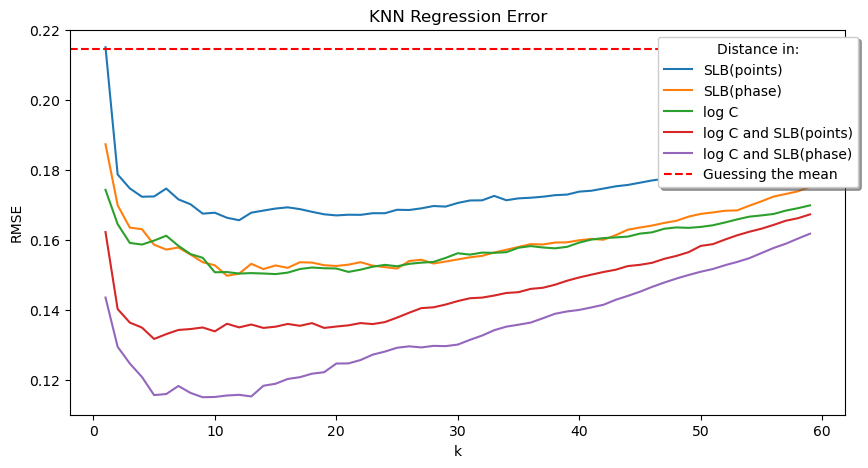

In [16]:
baseline = jnp.sqrt(jnp.mean(jnp.square(labels - labels.mean())))

fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(ks, losses, label="Distribution of distances")
ax.plot(ks, slb_losses, label="SLB(points)")
ax.plot(ks, slb_phase_losses, label="SLB(phase)")
ax.plot(ks, logc_losses, label="log C")
# ax.plot(ks, blend_losses, label="Combination of log C and log Distribution")
ax.plot(ks, blended_slb_losses, label="log C and SLB(points)")
ax.plot(ks, blended_slb_phase_losses, label="log C and SLB(phase)")

ax.axhline(baseline, color = "red", linestyle="dashed", label = "Guessing the mean")
ax.legend(loc='upper left', bbox_to_anchor=(0.75, 1.0),
          ncol=1, fancybox=True, shadow=True, title="Distance in:")

ax.set(ylabel="RMSE", xlabel="k", title="KNN Regression Error");